# Proj : 네이버 영화 리뷰 감성 분류에 SentnecePiece 적용해보기
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-03-18 06:36:20--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-03-18 06:36:20--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [ ]:
!tar -xzvf korean-english-park.train.tar.gz
# korean-english-park.train.ko 이걸로 학습

korean-english-park.train.en
korean-english-park.train.ko


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.2 MB/s 


# 1. 라이브러리 입력

In [ ]:
import sentencepiece as spm
import tensorflow as tf
import pandas as pd
import csv
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 2. 데이터 내려 받기, 데이터 정보 확인

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

train = pd.read_table('ratings_train.txt')
test = pd.read_table('ratings_test.txt')
sub = pd.read_table('ratings.txt')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


# 3. 중복제거 & 결측치 제거

In [ ]:
# 중복제거
train.drop_duplicates(subset = ['document'], inplace=True)
test.drop_duplicates(subset = ['document'], inplace=True)

# Nan 결측치 제거
train = train.dropna(how = 'any')
test = test.dropna(how = 'any')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


# 4. vocab 생성

In [ ]:
temp_file = 'korean-english-park.train.ko'
vocab_size = 8000
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size) +
    "--model_type=char" # model_type ='word' # Choose from unigram (default), bpe, char, or word
)

In [ ]:
vocab_list = pd.read_csv('korean_spm.vocab', sep='\t', header=None, quoting = csv.QUOTE_NONE)
vocab_list.sample(10)

,0,1
3427,▁않으면,-9.97331
460,▁발생한,-8.12605
1622,▁원인,-9.18494
6554,▁아빠,-10.88980
2947,▁지도자인,-9.82068
907,▁컴퓨터,-8.64184
1329,▁하마스,-8.98001
2647,▁출발,-9.68395
2426,▁수천,-9.60784
7126,있거나,-11.10160


# 5. 데이터 인코딩 & 불용어 제거

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus):
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    result = []
    for sentence in corpus:
        curr_data = []
        curr_data = s.encode_as_pieces(sentence)
        curr_data = [word for word in curr_data if not word in stopwords]
        result.append(curr_data)
    print(result[0])

    results = []
    
    for arr in result:
      r = ''
      for string in arr:
        if string == '▁':
          r += ' '
        else:
          r += string
      results.append(r)

    tensor = []

    for sen in results:
      tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    return tensor, word_index, index_word

1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [ ]:
# sp_tokenize(s, corpus) 사용예제
my_corpus = train.document
X_train, word_index, index_word = sp_tokenize(s, my_corpus)

['▁아', '▁더', '빙', '.', '.', '▁진', '짜', '▁', '짜', '증', '나', '네', '요', '▁목소리']


In [ ]:
X_train[0]

[147, 79, 2764, 4, 4, 950, 5068, 3, 5068, 811, 66, 578, 526, 2664]

In [ ]:
my_corpus = test.document
X_test, word_index, index_word = sp_tokenize(s, my_corpus)

['▁', '굳', '▁', 'ᄏ']


In [ ]:
print(len(X_test))
print(len(X_train))

49157
146182


# 6. 데이터 패딩

In [ ]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value = 0, padding = 'pre', maxlen = maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, value = 0, padding = 'pre', maxlen = maxlen)

In [ ]:
Y_train = np.array(list(train['label']))
Y_test = np.array(list(test['label']))

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(146182, 54)
(146182,)
(49157, 54)
(49157,)


# 7. 학습, val 데이터 생성

In [ ]:
x_val = X_train[:50000]
y_val = Y_train[:50000]

partial_x_train = X_train[50000:]
partial_y_train = Y_train[50000:]

# 8. 학습모델 생성

In [ ]:
vocab_size = 10000
word_vector_dim = 200 # 2의 배수

model_1 = keras.Sequential()
model_1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )))
model_1.add(keras.layers.LSTM(8))
model_1.add(keras.layers.Dense(8, activation='relu'))
model_1.add(keras.layers.Dense(1,activation='sigmoid'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


# 9. 데이터 학습

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # optimizer -> adam 이 제일 좋다
# binary_crossentropy 이진 분류에 사용

epochs = 100

history = model_1.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val),callbacks = [early_stopping],
                    verbose=1)

Epoch 1/100
188/188 [==============================] - 12s 25ms/step - loss: 0.4890 - accuracy: 0.7769 - val_loss: 0.4131 - val_accuracy: 0.8156
Epoch 2/100
188/188 [==============================] - 4s 21ms/step - loss: 0.3911 - accuracy: 0.8284 - val_loss: 0.3991 - val_accuracy: 0.8221
Epoch 3/100
188/188 [==============================] - 4s 20ms/step - loss: 0.3643 - accuracy: 0.8425 - val_loss: 0.3898 - val_accuracy: 0.8254
Epoch 4/100
188/188 [==============================] - 4s 19ms/step - loss: 0.3420 - accuracy: 0.8556 - val_loss: 0.3875 - val_accuracy: 0.8302
Epoch 5/100
188/188 [==============================] - 3s 18ms/step - loss: 0.3197 - accuracy: 0.8655 - val_loss: 0.3840 - val_accuracy: 0.8334
Epoch 6/100
188/188 [==============================] - 3s 18ms/step - loss: 0.2986 - accuracy: 0.8757 - val_loss: 0.3814 - val_accuracy: 0.8353
Epoch 7/100
188/188 [==============================] - 4s 19ms/step - loss: 0.2772 - accuracy: 0.8860 - val_loss: 0.3925 - val_accuracy

In [ ]:
model_1.evaluate(X_test,Y_test, verbose = 2)

1537/1537 - 8s - loss: 0.5550 - accuracy: 0.8225 - 8s/epoch - 5ms/step


[0.5549853444099426, 0.8225075006484985]

# 10. 학습,val 데이터 loss값 그래프로 표현

In [ ]:
history_dict = history.history

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

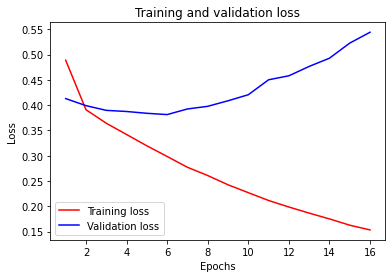

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label= 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 11. 예측 정확도 확인

In [ ]:
arr = model_1.predict(X_test)
answer = []
for i in arr:
  if i >= 0.5:
    answer.append(1)
  else:
    answer.append(0)
num = 0
for i, j in zip(Y_test,answer):
  if i != j:
    num += 1
print(num)

8725


In [ ]:
acc = (len(Y_test) - num)/len(Y_test)
acc

0.8225074760461378